# CharRNN

# Import

For Data Processing

In [1]:
import re
import random
import string

For Model Building

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

For PostProcessing

In [3]:
import matplotlib.pyplot as plt

# Read Data

In [4]:
all_chars = string.printable
total_num_chars = len(all_chars)

f = open("./Data/tinyshakespeare.txt","r")
content = f.read()
content_length = len(content)

Split Train and Valid

In [5]:
train_chars = content[:-5000]
valid_chars = content[-5000:]

Obtain Mini-batch, define size of mini-batch here

In [6]:
MINIBATCH = 200

Useful Functions for Feature Generation

In [7]:
def random_batch_char():
    random_index = random.randint(0, len(train_chars) - MINIBATCH-1)
    return train_chars[random_index:random_index+MINIBATCH+1]

In [8]:
def char2tensor(inputs):
    t = torch.zeros(len(inputs)).long()
    for count in range(len(inputs)):
        t[count] = all_chars.index(inputs[count])
    return Variable(t)

In [9]:
def random_training_batch():
    batch_chars = random_batch_char()
    inputs = char2tensor(batch_chars[:-1])
    tags = char2tensor(batch_chars[1:])
    return inputs, tags

# Define Model

In [10]:
class RNN(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, n_layers=1):
        super(RNN,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_dim, hidden_dim)
        self.net = nn.RNN(hidden_dim, hidden_dim, n_layers)
        self.decoder = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, inputs, hidden):
        inputs = self.encoder(inputs.view(1,-1))
        output, hidden = self.net(inputs.view(1,1,-1),hidden)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def hidden_init(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_dim))

Configure Parameter

In [12]:
NUM_LAYER = 2
HIDDEN_DIM = 100
model = RNN(total_num_chars, HIDDEN_DIM, total_num_chars, NUM_LAYER)

# Training Process

In [13]:
MAX_ITERATION = 20000
PRINT_PER = 100
LEARNING_RATE = 0.005

In [14]:
model_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [15]:
def train(inputs, tags):
    hidden = model.hidden_init()
    model.zero_grad()
    loss = 0
    for count in range(MINIBATCH):
        output, hidden = model(inputs[count], hidden)
        loss += criterion(output, tags[count])  
    loss.backward()
    model_optimizer.step()
    return loss.data[0]/MINIBATCH

def valid(inputs, tags):
    hidden = model.hidden_init()
    model.zero_grad()
    loss = 0
    for count in range(len(inputs)):
        output, hidden = model(inputs[count], hidden)
        loss += criterion(output, tags[count]) 
    return loss.data[0]/len(inputs)

In [16]:
saved_train_loss = []
saved_valid_loss = []

In [17]:
valid_inputs = char2tensor(valid_chars[:-1])
valid_tags = char2tensor(valid_chars[1:])

In [18]:
averaged_loss = 0
for epoch in range(1,MAX_ITERATION):
    loss = train(*random_training_batch())
    averaged_loss += loss
    if epoch % PRINT_PER == 0:
        valid_loss = train(valid_inputs,valid_tags)
        print("epoch: " + str(epoch) + "\ttrain_loss: " + 
              str(averaged_loss/PRINT_PER) + "\tvalid_loss: " +
             str(valid_loss))
        saved_train_loss.append(averaged_loss/PRINT_PER)
        saved_valid_loss.append(valid_loss)
        averaged_loss = 0
    

epoch: 100	train_loss: 2.6798820022582994	valid_loss: 2.31484619140625
epoch: 200	train_loss: 2.2587296020507814	valid_loss: 2.2268080139160156
epoch: 300	train_loss: 2.1239385696411124	valid_loss: 2.1820521545410156
epoch: 400	train_loss: 2.0760495422363268	valid_loss: 2.1079635620117188
epoch: 500	train_loss: 2.0276438873291016	valid_loss: 2.004838562011719
epoch: 600	train_loss: 2.009122587585449	valid_loss: 1.9932798767089843
epoch: 700	train_loss: 1.9678204635620116	valid_loss: 1.972063751220703
epoch: 800	train_loss: 1.957312049865723	valid_loss: 1.923255615234375
epoch: 900	train_loss: 1.947547811889648	valid_loss: 1.9444371032714844
epoch: 1000	train_loss: 1.9014023727417	valid_loss: 1.9235942077636718
epoch: 1100	train_loss: 1.890026623535156	valid_loss: 1.9400015258789063
epoch: 1200	train_loss: 1.905540193176269	valid_loss: 1.8672660827636718
epoch: 1300	train_loss: 1.9127606140136717	valid_loss: 1.8799786376953125
epoch: 1400	train_loss: 1.8600975112915037	valid_loss: 1.827

KeyboardInterrupt: 

# Plot

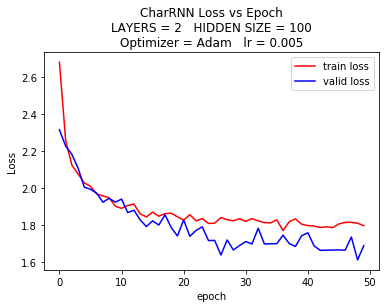

In [19]:
plt.figure()
plt.title('CharRNN Loss vs Epoch\n'+'LAYERS = '+str(NUM_LAYER)+'   HIDDEN SIZE = '+str(HIDDEN_DIM)+'\nOptimizer = Adam'+'   lr = '+str(LEARNING_RATE))
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(saved_train_loss,'red')
plt.plot(saved_valid_loss,'blue')
plt.legend(['train loss','valid loss'])
plt.savefig('HW4_CharRNN_loss_'+str(NUM_LAYER)+'_hidden_'+str(HIDDEN_DIM)+'_Adam_lr_'+str(LEARNING_RATE)[2:])
plt.show()

# Genreate New Content

In [20]:
def generator(prime, gen_length, temperature):
    hidden = model.hidden_init()
    prime_tensor = char2tensor(prime)
    result_str = prime
    
    # Initialize the model by prime input
    for num in range(len(prime_tensor)-1):
        _, hidden = model(prime_tensor[num], hidden)
    inputs = prime_tensor[-1]
    
    # Start generating
    for count in range(gen_length):
        output, hidden = model(inputs, hidden)
        
        # Get Predict Result based on the probability divided by temperature
        p_dist = output.data.view(-1).div(temperature).exp()
        result_idx = torch.multinomial(p_dist, 1)[0]

        # Collect the predicted result
        next_char = all_chars[result_idx]
        result_str += next_char
        inputs = char2tensor(next_char)
    
    return result_str

In [31]:
PRIME = 'CORIOLANUS:'
PREDICT_LENGTH = 5000
T = 0.7
print(generator(PRIME,PREDICT_LENGTH,T))

CORIOLANUS:
Now had the gons as will, but he broud shall and, not names his callaw of repolk, and speal.

ROMEO:
Hall than she the regue comes hand the geast be the resentleman:
Ef thou planged of retiences no coming strounce,
He the westand cangues him, for strusharl did centers,
There, not man arull the dights earth the fair of saw I the king,
That there that see I disson Bursand the sweet see ceoreman shore your purpteeth should surthing by Romenter hold so as malan is shall sore his which have of ming not dis, but the give here,
That shward the death destreen croving and this cannot to that where, latuers are sund and that may say.

FRIARET:
Havour man the percountle will mad searst stords, and worp,
Or not who provonds charkn that sees no spoll all rasher'd, parth 'trursested may from your cray shall breather.

HORTENRY:
Henrst my so will and for hath deather for spear him that the seem forthing in sweet the broke shall time that, God anger, grief,
Thee strusters, she part these r